# Project I - Drug_Spectra
### Author: Peter Martigny
### M2 Data Science Paris Saclay

### The problem proposes to carry out analysis and prediction for chemical purposes

#### The goal is to predict the molecule present in a chemical solution, and its concentration, given its Raman Spectrum

Hence, the problem can be separated into 2 separate problems: 

- Classification problem: Can you predict which molecule is present in this solution?
- Regression problem: Can you predict the concentration of the molecule in the solution?

First import useful libraries

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

from sklearn.model_selection  import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import GradientBoostingRegressor   
import xgboost as xgb

C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Load the Data

In [2]:
# Load the training data
data = pd.read_csv('train.csv')

y_df = data[['molecule', 'concentration']]
X_df = data.drop(['molecule', 'concentration'], axis=1)
spectra = X_df['spectra'].values                                        
spectra = np.array([np.array(dd[1:-1].split(',')).astype(float) for dd in spectra])    
X_df['spectra'] = spectra.tolist()

# Loading wavenumbers
freqs = pd.read_csv('freq.csv')
freqs = freqs['freqs'].values

## Define targets and Features
# Target for classification
molecule = y_df['molecule'].values
# Target for regression
concentration = y_df['concentration'].values
# "Raw" features
X = spectra

In [3]:
X_df.head()

,solute,spectra,vial
0,11,"[0.0152963, 0.0152944, 0.0153142, 0.0154096, 0...",1
1,1,"[0.0143634, 0.0143292, 0.0143999, 0.0145162, 0...",1
2,3,"[0.0163027, 0.0161848, 0.0163573, 0.0164119, 0...",1
3,10,"[0.0135833, 0.0135537, 0.0134438, 0.0136424, 0...",2
4,2,"[0.020811, 0.020767, 0.0208674, 0.0207018, 0.0...",3


The training data consists in $3$ columns, giving the type of solute in which the molecule is diluted, the vial type (type of container) and the whole Raman spectrum, consisting of the measures of $1866$ intensities at different frequencies given in the freq object.

We will focus only on the Raman spectrum to make our predictions. Hence we create a nummpy array $X$ containing all spectra from the training dataset.

In [4]:
y_df.head(2)

,molecule,concentration
0,Q,8000
1,B,500


The prediction are made on $2$ columns: 
- Predict the molecule
- Predict the concentration

### Explore the variables to predict 

#### The molecules

In [5]:
np.unique(y_df['molecule'].values)

array(['A', 'B', 'Q', 'R'], dtype=object)

There are $4$ different molecules to be considered in the problem.

Number of samples: 999


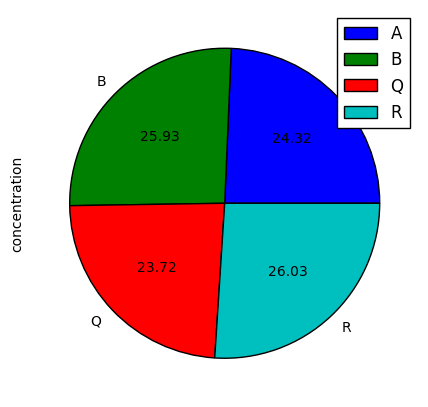

In [6]:
print('Number of samples: %s' % len(y_df))
y_df.groupby('molecule').count().plot(y='concentration', kind='pie', autopct='%.2f', figsize=(5, 5));

We have approximately the same representation for each molecule in the training dataset.

#### The concentration

There are 21 different values of concentrations.


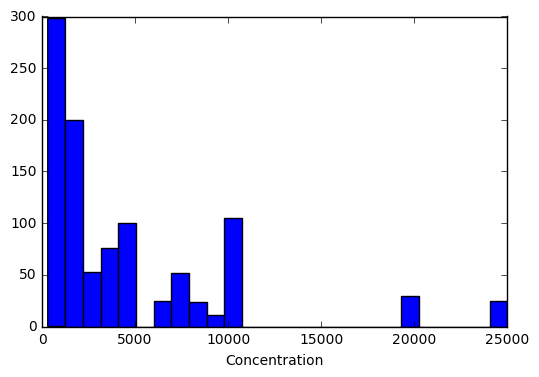

In [7]:
plt.hist(concentration, bins=26)
plt.xlabel('Concentration')
print("There are %s different values of concentrations." % np.unique(concentration).size)

The concentrations are below $5 000$ (which unit?) for most samples, but we still have a few samples with large concentrations, larger than $15 000$.

Our regression metricis the Mean Absolute Relative error (MARE): 

$$
\frac{1}{n_{samples}}\sum_{i = 1}^{n_{samples}}|\frac{y_i - \hat {y_i}}{y_i}|
$$

Hence, a given absolute difference will have a bigger impact for small concentrations than for large concentrations.

In [8]:
# Number of different concentrations
y_df.concentration.unique().shape

(21,)

There are only $21$ different concentrations in the whole training dataset. We could think of approaching the problem as a multilabel classification, with 21 labels. But we will prefer the regression approach.

#### Link between molecules and concentrations

[  300   400   600   800  1000  1400  1600  2000  5000 10000]
[  500  1000  1500  2000  4000  5000  7000 10000 20000 25000]
[ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]
[  400   800  1000  1200  1600  2000  3000  4000  5000 10000]


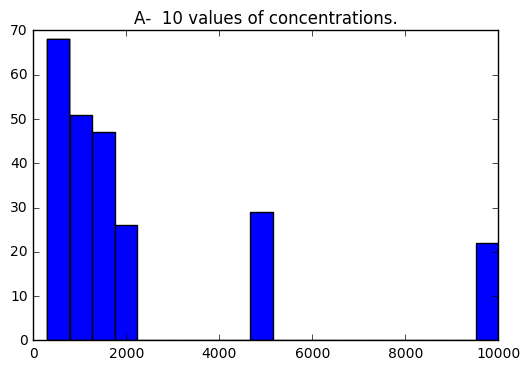

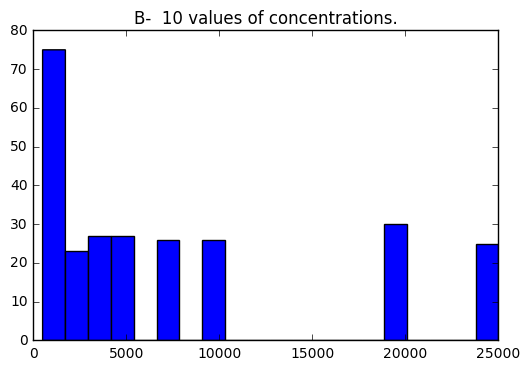

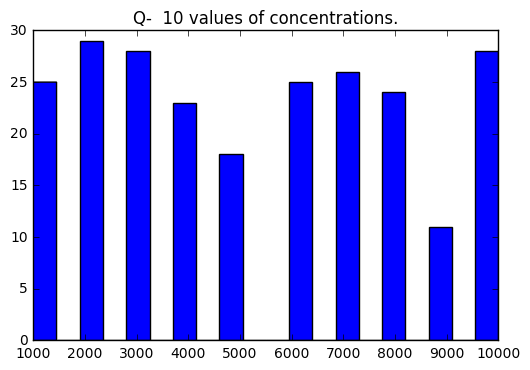

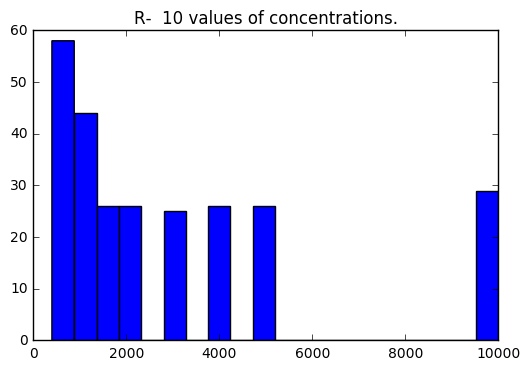

In [9]:
for mol in np.unique(molecule):
    plt.figure()
    plt.hist(concentration[molecule == mol], bins=20)
    plt.title(mol + "-  %s values of concentrations."
              % np.unique(concentration[molecule == mol]).size)
    print(np.unique(concentration[molecule == mol]))

Molecule Q has different concentration uniformly shared between $1000$ and $10000$, whereas the other molecules have more low concentrations, and fewer larger concentrations.

### Explore the Raman Spectra

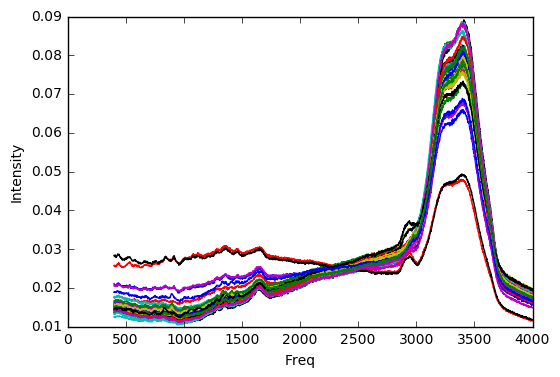

In [10]:
plt.plot(freqs, spectra[100:130].T)
plt.xlabel('Freq')
plt.ylabel('Intensity')

In the theory of Raman spectra, molecules can be spotted using the frequencies with peaks in intensities. We see here that the 4 molecules have their highest peak at approximately the same frequency. 
Hence, the classification is not trivial.

The similarity of the peak locality is explained by the fact that the $4$ molecules considered here all have specific chemical properties of chemiotherapy, which means that they surely share a lot of chemical groups, which are responsible for the frequencies which are the most absobed.

### Link between Raman Spectra and molecules

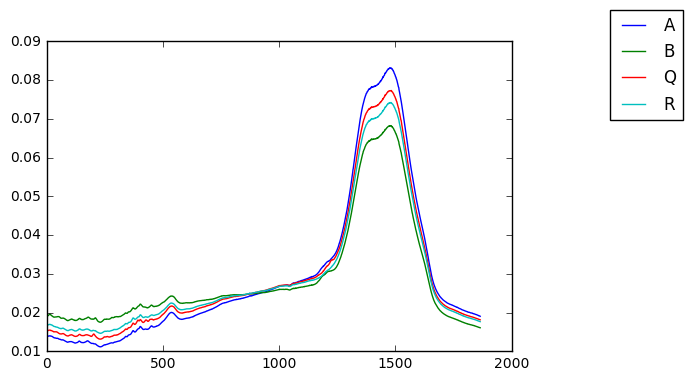

In [11]:
# Plot the mean Raman Spectrum for each molecule
for mol in np.unique(molecule):
    plt.plot(np.mean(X[molecule == mol, :], axis=0), label="%s" % mol)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

Molecule A seems to have a highest peak than the others, folloed by molecules Q, R and B.

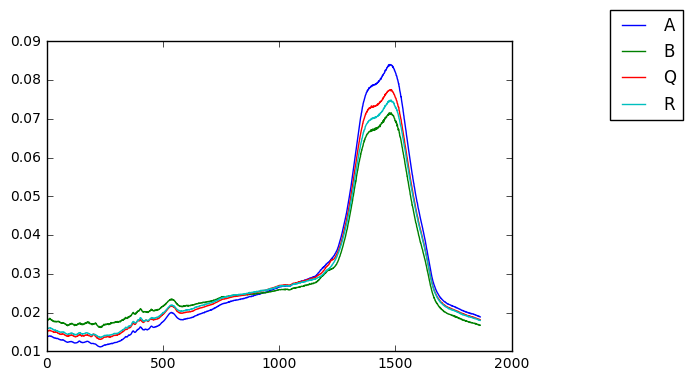

In [12]:
# Plot the median Raman Spectrum for each molecule
for mol in np.unique(molecule):
    plt.plot(np.median(X[molecule == mol, :], axis=0), label="%s" % mol)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

It seems that this order is preserved when we take the median Raman spectrum instead of the mean.

Now, we'd like to know whether the molecules are cloes to their mean/median or not.

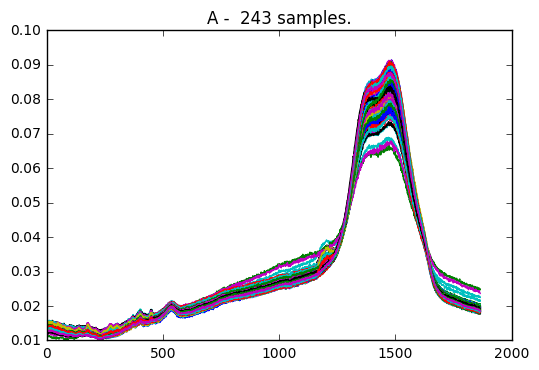

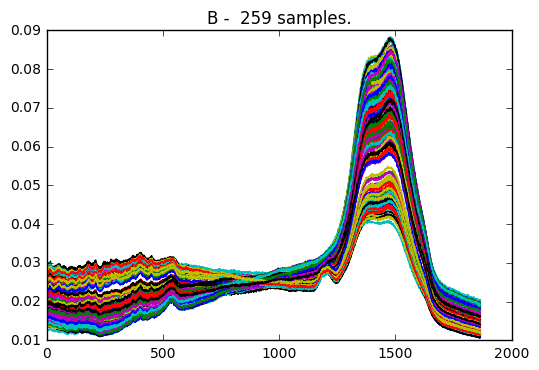

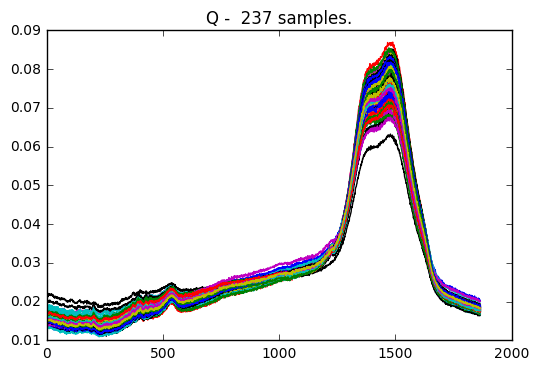

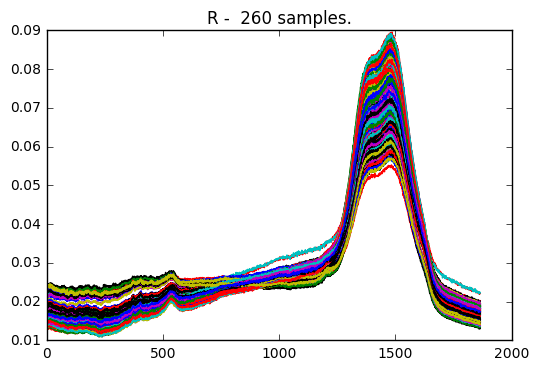

In [13]:
# Raman Spectrum for each molecule
for mol in np.unique(molecule):
    plt.figure()
    plt.plot(X[molecule == mol, :].T)
    plt.title(mol + " -  %s samples." % X[molecule == mol, :].shape[0])


Molecules B and R are really much fetched at the largest peak, whereas molecules A and Q have less variance at the largest peak.

It may also be good to consider the variance in each of the classes represented

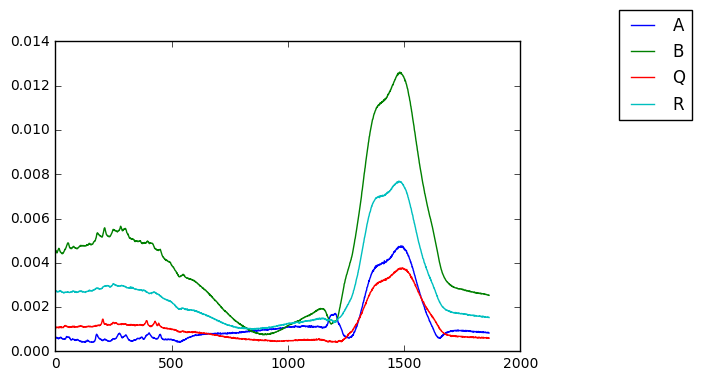

In [14]:
# Plot the median Raman Spectrum for each molecule
for mol in np.unique(molecule):
    plt.plot(np.std(X[molecule == mol, :], axis=0), label="%s" % mol)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

By looking at the previous plot, we see that the area around the highest intensity peak is also the area of a peak in the standard deviation. Hence, the points measured iin this area may not be that useful in the classification task.

### Link between Raman spectrum and concentrations

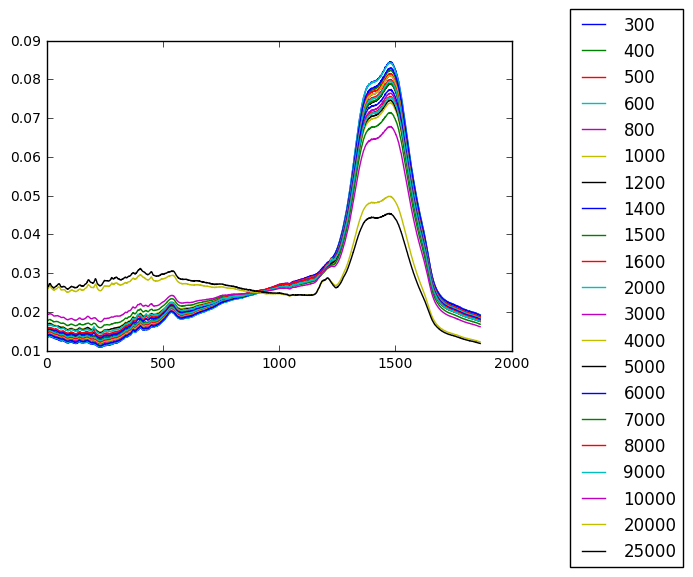

In [15]:
# Mean spectrum for each concentration
for c in np.unique(concentration):
    plt.plot(np.mean(X[concentration == c, :], axis=0), label="%s" % c)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

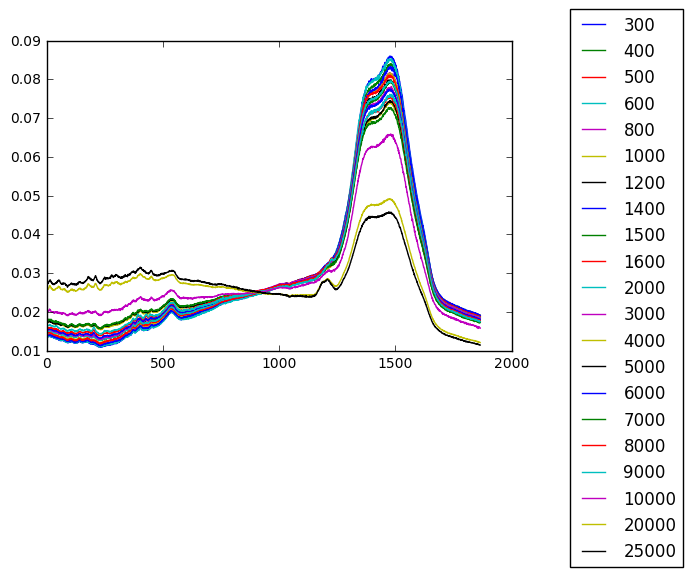

In [16]:
# Median spectrum for each concentration
for c in np.unique(concentration):
    plt.plot(np.median(X[concentration == c, :], axis=0), label="%s" % c)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

For the mean as for the median, the order seems to be the same: the larger the concentration, the lower the peak in intensity.

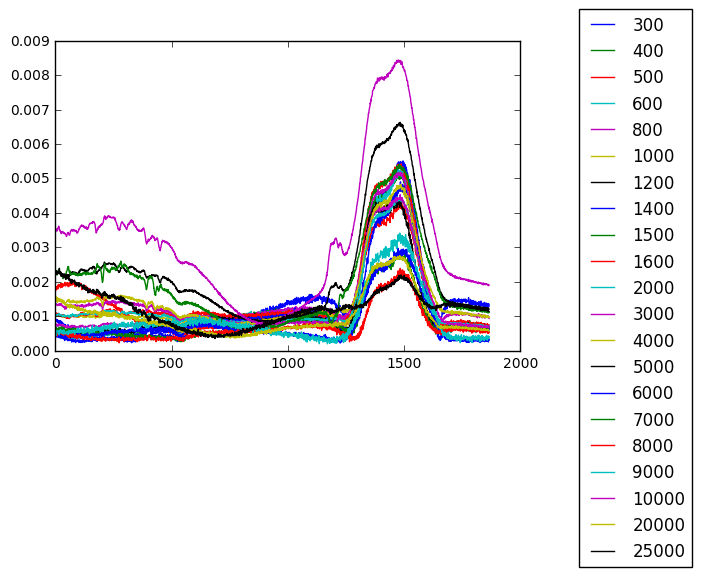

In [17]:
# Standard deviation spectrum for each concentration
for c in np.unique(concentration):
    plt.plot(np.std(X[concentration == c, :], axis=0), label="%s" % c)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

We notice that here there are different zones where each concentration has a small spread.

# Classification part
### Let's start from the starting kit

We first define a class to extract features for classification

In [18]:
class FeatureExtractorClf(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_df):
        pass
    
    def transform(self, X_df):
        XX = np.array([np.array(dd) for dd in X_df['spectra']])
        return XX

Then, we define a class to classify the molecules

In [19]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

class Classifier(BaseEstimator):
    def __init__(self):
        self.n_components = 100
        self.n_estimators = 300
        self.clf = Pipeline([
            ('pca', PCA(n_components=self.n_components)), 
            ('clf', RandomForestClassifier(n_estimators=self.n_estimators, random_state=42))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Let's put them together and form a baseline estimator

In [20]:
from sklearn.model_selection  import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

labels = np.array(['A', 'B', 'Q', 'R'])

def train_test_model_clf(X_df, y_df, skf_is, FeatureExtractor, Classifier):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()
    y_train_clf = y_train_df['molecule'].values
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy() 
    y_test_clf = y_test_df['molecule'].values 
    # Feature extraction
    fe_clf = FeatureExtractor()
    fe_clf.fit(X_train_df, y_train_df)
    X_train_array_clf = fe_clf.transform(X_train_df)
    X_test_array_clf = fe_clf.transform(X_test_df)
    # Train
    clf = Classifier()
    clf.fit(X_train_array_clf, y_train_clf)
    # Test 
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = %s' % error)                                                                            
    print('classification report:\n %s' % classification_report(y_test_clf, y_pred_clf))
    print('confusion matrix:\n %s' % confusion_matrix(y_test_clf, y_pred_clf))


skf = ShuffleSplit(n_splits =2, test_size=0.2, random_state=57)  
skf_is = list(skf.split(X_df))[0]

train_test_model_clf(X_df, y_df, skf_is, FeatureExtractorClf, Classifier)

error = 0.125
classification report:
              precision    recall  f1-score   support

          A       0.86      0.87      0.87        63
          B       0.77      0.89      0.82        45
          Q       0.97      0.90      0.94        40
          R       0.94      0.85      0.89        52

avg / total       0.88      0.88      0.88       200

confusion matrix:
 [[55  6  1  1]
 [ 3 40  0  2]
 [ 3  1 36  0]
 [ 3  5  0 44]]


#### Interpretation: what does this code do?

- First, the feature extractor produces a 2D numpy array with all the raw intensities
- Then, the classification pipeline consists in two parts: 
    - A PCA to reduce the dimension
    - A Random Forest classifier
    
We use a shufflesplit with a fixed random state of $57$. In order not to overfit, it is preferable to give it up. 

In [21]:
for i in range(3):
    skf = ShuffleSplit(n_splits =2, test_size=0.2)  
    skf_is = list(skf.split(X_df))[0]
    train_test_model_clf(X_df, y_df, skf_is, FeatureExtractorClf, Classifier)

error = 0.08
classification report:
              precision    recall  f1-score   support

          A       0.88      0.90      0.89        42
          B       0.88      0.93      0.90        55
          Q       1.00      0.89      0.94        53
          R       0.92      0.96      0.94        50

avg / total       0.92      0.92      0.92       200

confusion matrix:
 [[38  4  0  0]
 [ 4 51  0  0]
 [ 0  2 47  4]
 [ 1  1  0 48]]
error = 0.105
classification report:
              precision    recall  f1-score   support

          A       0.82      0.91      0.86        45
          B       0.85      0.83      0.84        53
          Q       1.00      0.98      0.99        42
          R       0.93      0.88      0.91        60

avg / total       0.90      0.90      0.90       200

confusion matrix:
 [[41  2  0  2]
 [ 7 44  0  2]
 [ 0  1 41  0]
 [ 2  5  0 53]]
error = 0.095
classification report:
              precision    recall  f1-score   support

          A       0.79      0.8

By running several times the algorithm, we find that its error rate varies around $0.1$, with a non negligible variance.
We notice thanks to the confusion matrices that the molecule Q is the most well-classified, whereas the other three molecules still poses problems.

#### Is it possible to do a better job?

Still looking at random forest classifier, we have mostly $2$ ways to improve the results: 

- Improving the variables selection: 
    - Optimize parameters of PCA, such as the number of components
    - Change the dimension reduction technique (NMF, SVD, KernelPCA...)
    - Manual feature engineering
    
- Optimize the parameters of the random forest classifier

The optimization is made using Grid Search combined with 5-fold Cross-Validation

In [22]:
from sklearn.model_selection import GridSearchCV

# Samples the train test split
skf = ShuffleSplit(n_splits =2, test_size=0.2)  
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()
y_train_clf = y_train_df['molecule'].values
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy() 
y_test_clf = y_test_df['molecule'].values 
# Feature extraction
fe_clf = FeatureExtractorClf()
fe_clf.fit(X_train_df, y_train_df)
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)


# Dimension Reduction
pca = PCA(n_components=50)
pca.fit(X_train_array_clf)
X_train_array_clf = pca.transform(X_train_array_clf)

params = {'n_estimators': [50, 75, 100, 125, 150, 175, 200],
         'max_features': ['sqrt', 'log2']}
clf = GridSearchCV(RandomForestClassifier(), params, scoring='accuracy', cv = 5, 
                   n_jobs=4)
clf.fit(X_train_array_clf, y_train_clf)
# Print the mean scores for each parameter over the different CV
clf.cv_results_['mean_test_score']

array([ 0.90237797,  0.90237797,  0.89987484,  0.91113892,  0.89862328,
        0.91489362,  0.91364205,  0.89111389,  0.88610763,  0.90237797,
        0.91364205,  0.90613267,  0.91489362,  0.90988736])

In [23]:
# Then, we test using the best parameter obtained in the grid
X_test_array_clf = pca.transform(X_test_array_clf)
y_proba_clf = clf.predict_proba(X_test_array_clf)                        
y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
print('error = %s' % error)  

error = 0.07


Here, we can see that we have improve a little bit our implementation by optimizing the parameters of the Random Forest.
What about the optimization of the PCA now?
We can do a GridSearch over the pipeline PCA - Random Forest Classifier

In [24]:
# Samples the train test split
skf = ShuffleSplit(n_splits =2, test_size=0.2)  
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()
y_train_clf = y_train_df['molecule'].values
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy() 
y_test_clf = y_test_df['molecule'].values 
# Feature extraction
fe_clf = FeatureExtractorClf()
fe_clf.fit(X_train_df, y_train_df)
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)

# Build pipeline
estimators = [('reduce_dim', PCA()), ('clf', RandomForestClassifier())]
pipe = Pipeline(estimators)

# Build the Grid of parameters
params = {'reduce_dim__n_components': [20, 30, 40, 50],
          'clf__n_estimators': [50, 75, 100, 125, 150, 175, 200],
         'clf__max_features': ['sqrt', 'log2']}

clf = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv = 5, 
                   n_jobs=4)
clf.fit(X_train_array_clf, y_train_clf)
# Print the mean scores for each parameter over the different CV
clf.cv_results_['mean_test_score']

array([ 0.90362954,  0.89612015,  0.89987484,  0.88235294,  0.93241552,
        0.90863579,  0.9048811 ,  0.89987484,  0.91364205,  0.91989987,
        0.89612015,  0.91113892,  0.91739675,  0.90738423,  0.91113892,
        0.89987484,  0.922403  ,  0.90988736,  0.91113892,  0.91113892,
        0.92115144,  0.91239049,  0.90613267,  0.90112641,  0.91864831,
        0.91489362,  0.91364205,  0.89987484,  0.91489362,  0.89862328,
        0.89111389,  0.8873592 ,  0.90738423,  0.89612015,  0.91489362,
        0.8873592 ,  0.91614518,  0.90362954,  0.90613267,  0.88861076,
        0.91739675,  0.91113892,  0.89862328,  0.89486859,  0.92490613,
        0.91614518,  0.90362954,  0.89236546,  0.91489362,  0.91614518,
        0.89486859,  0.89236546,  0.91614518,  0.90988736,  0.90362954,
        0.89361702])

In [25]:
# The, we test using the best parameter obtained in the grid
y_proba_clf = clf.predict_proba(X_test_array_clf)                        
y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
print('error = %s' % error) 

error = 0.055


Hence, we have improved the algorithm by several % using Grid search and Cross Validation.

Now, what if we wanted to test other algorithms?

#### Logistic Rgression

In [28]:
from sklearn.linear_model import LogisticRegression

# Samples the train test split
skf = ShuffleSplit(n_splits =2, test_size=0.2)  
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()
y_train_clf = y_train_df['molecule'].values
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy() 
y_test_clf = y_test_df['molecule'].values 
# Feature extraction
fe_clf = FeatureExtractorClf()
fe_clf.fit(X_train_df, y_train_df)
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)


# Dimension Reduction
pca = PCA(n_components=50)
pca.fit(X_train_array_clf)
X_train_array_clf = pca.transform(X_train_array_clf)

clf = LogisticRegression(C = 10000)
clf.fit(X_train_array_clf, y_train_clf)

# Then, we test using the best parameter obtained in the grid
X_test_array_clf = pca.transform(X_test_array_clf)
y_proba_clf = clf.predict_proba(X_test_array_clf)                        
y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
print('error = %s' % error)  

error = 0.07


We notice that, by using simple Logistic Regression without any parameter tuning, we are able to improve our baseline as our optimized baseline.
We also notice that the computation is shorter than with random forest (here the algorithm is launched once, unlike random forest and its n_estimators arbitrarily high). This will help us use GridSearch CV over a large grid of parameters.

Since there is already a dimension reduction through PCA, we will do very little regularization, hence we will choose high values for the C parameter.

In [29]:
# Samples the train test split
skf = ShuffleSplit(n_splits =2, test_size=0.2)  
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()
y_train_clf = y_train_df['molecule'].values
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy() 
y_test_clf = y_test_df['molecule'].values 
# Feature extraction
fe_clf = FeatureExtractorClf()
fe_clf.fit(X_train_df, y_train_df)
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)

# Build pipeline
estimators = [('reduce_dim', PCA()), ('clf', LogisticRegression())]
pipe = Pipeline(estimators)

# Build the Grid of parameters
params = {'reduce_dim__n_components': [20, 30, 40, 50],
          'clf__penalty': ['l1', 'l2'],
         'clf__C': [1000, 2000]}

clf = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv = 5, 
                   n_jobs=4)
clf.fit(X_train_array_clf, y_train_clf)
# Print the mean scores for each parameter over the different CV
clf.cv_results_['mean_test_score']

array([ 0.9612015 ,  0.95994994,  0.95619524,  0.95869837,  0.8485607 ,
        0.8485607 ,  0.8485607 ,  0.8485607 ,  0.95869837,  0.95369212,
        0.95619524,  0.95994994,  0.86858573,  0.86858573,  0.86858573,
        0.86858573])

In [30]:
y_proba_clf = clf.predict_proba(X_test_array_clf)                        
y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
print('error = %s' % error)  

error = 0.045


Hence, we have lowered our error loss.

#### Support Vector Classification

In [36]:
from sklearn.svm import SVC

# Samples the train test split
skf = ShuffleSplit(n_splits =2, test_size=0.2)  
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()
y_train_clf = y_train_df['molecule'].values
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy() 
y_test_clf = y_test_df['molecule'].values 
# Feature extraction
fe_clf = FeatureExtractorClf()
fe_clf.fit(X_train_df, y_train_df)
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)


# Dimension Reduction
pca = PCA(n_components=50)
pca.fit(X_train_array_clf)
X_train_array_clf = pca.transform(X_train_array_clf)

clf = SVC(probability=True, C = 10000, gamma = 1)
clf.fit(X_train_array_clf, y_train_clf)

# Then, we test using the best parameter obtained in the grid
X_test_array_clf = pca.transform(X_test_array_clf)
y_proba_clf = clf.predict_proba(X_test_array_clf)                        
y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
print('error = %s' % error)  

error = 0.045


SVC gives a first result similar to the one of Logistic Regression. Let's try to fine tune it: 

In [37]:
# Samples the train test split
skf = ShuffleSplit(n_splits =2, test_size=0.2)  
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()
y_train_clf = y_train_df['molecule'].values
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy() 
y_test_clf = y_test_df['molecule'].values 
# Feature extraction
fe_clf = FeatureExtractorClf()
fe_clf.fit(X_train_df, y_train_df)
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)

# Build pipeline
clf = SVC(probability=True)
estimators = [('reduce_dim', PCA()), ('clf', SVC(probability=True))]
pipe = Pipeline(estimators)

# Build the Grid of parameters
params = {'reduce_dim__n_components': [20, 30, 40, 50],
         'clf__C': [1000, 2000],
         'clf__gamma': [10, 50]}

clf = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv = 5, 
                   n_jobs=4)
clf.fit(X_train_array_clf, y_train_clf)
# Print the mean scores for each parameter over the different CV
clf.cv_results_['mean_test_score']

array([ 0.93617021,  0.93491865,  0.93617021,  0.93867334,  0.93742178,
        0.94117647,  0.93617021,  0.94493116,  0.94743429,  0.94993742,
        0.94743429,  0.94743429,  0.93992491,  0.93992491,  0.94242804,
        0.94493116])

In [38]:
y_proba_clf = clf.predict_proba(X_test_array_clf)                        
y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
print('error = %s' % error) 

error = 0.055


#### What if we wanted to combine those two last models?

In [39]:
from sklearn.ensemble import VotingClassifier

# Samples the train test split
skf = ShuffleSplit(n_splits =2, test_size=0.2)  
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()
y_train_clf = y_train_df['molecule'].values
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy() 
y_test_clf = y_test_df['molecule'].values 
# Feature extraction
fe_clf = FeatureExtractorClf()
fe_clf.fit(X_train_df, y_train_df)
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)

# Build first model
clf1 = SVC(probability=True)
estimators1 = [('reduce_dim', PCA()), ('clf', SVC(probability=True))]
pipe1 = Pipeline(estimators1)
params1 = {'reduce_dim__n_components': [20, 30, 40, 50],
         'clf__C': [1000, 2000],
         'clf__gamma': [10, 50]}
clf1 = GridSearchCV(pipe1, param_grid=params1, scoring='accuracy', cv = 5)

# Build second model
estimators2 = [('reduce_dim', PCA()), ('clf', LogisticRegression())]
pipe2 = Pipeline(estimators2)
params2 = {'reduce_dim__n_components': [20, 30, 40, 50],
          'clf__penalty': ['l1', 'l2'],
         'clf__C': [1000, 2000]}
clf2 = GridSearchCV(pipe2, param_grid=params2, scoring='accuracy', cv = 5)

# Build the voting model
clf = VotingClassifier(estimators=[
        ('log', clf1), ('svc', clf2)], voting='soft')

# Train the voting model
clf.fit(X_train_array_clf, y_train_clf)
# Make predictions
y_proba_clf = clf.predict_proba(X_test_array_clf)                        
y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
print('error = %s' % error) 

error = 0.02


Test it on the pipeline

In [40]:
class Classifier(BaseEstimator):
    def __init__(self):

        
        self.estimators1 = [('reduce_dim', PCA()), ('clf', SVC(probability=True))]
        self.estimators2 = [('reduce_dim', PCA()), ('clf', LogisticRegression())]
        
        self.params1 = {'reduce_dim__n_components': [20, 30, 40, 50],
         'clf__C': [1000, 2000],
         'clf__gamma': [10, 50]}
        self.params2 = {'reduce_dim__n_components': [20, 30, 40, 50],
          'clf__penalty': ['l1', 'l2'],
         'clf__C': [1000, 2000]}
        
        self.clf1 = GridSearchCV(Pipeline(self.estimators1), param_grid=self.params1, scoring='accuracy', cv = 5)
        self.clf2 = GridSearchCV(Pipeline(self.estimators2), param_grid=self.params2, scoring='accuracy', cv = 5)
        
        self.clf = VotingClassifier(estimators=[
        ('log', self.clf1), ('svc', self.clf2)], voting='soft')
        
        

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [41]:
def train_test_model_clf(X_df, y_df, skf_is, FeatureExtractor, Classifier):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()
    y_train_clf = y_train_df['molecule'].values
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy() 
    y_test_clf = y_test_df['molecule'].values 
    # Feature extraction
    fe_clf = FeatureExtractor()
    fe_clf.fit(X_train_df, y_train_df)
    X_train_array_clf = fe_clf.transform(X_train_df)
    X_test_array_clf = fe_clf.transform(X_test_df)
    # Train
    clf = Classifier()
    clf.fit(X_train_array_clf, y_train_clf)
    # Test 
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = %s' % error)                                                                            
    print('classification report:\n %s' % classification_report(y_test_clf, y_pred_clf))
    print('confusion matrix:\n %s' % confusion_matrix(y_test_clf, y_pred_clf))


skf = ShuffleSplit(n_splits =2, test_size=0.2, random_state=57)  
skf_is = list(skf.split(X_df))[0]

train_test_model_clf(X_df, y_df, skf_is, FeatureExtractorClf, Classifier)

error = 0.035
classification report:
              precision    recall  f1-score   support

          A       0.98      0.94      0.96        63
          B       0.95      0.93      0.94        45
          Q       1.00      1.00      1.00        40
          R       0.93      1.00      0.96        52

avg / total       0.97      0.96      0.96       200

confusion matrix:
 [[59  2  0  2]
 [ 1 42  0  2]
 [ 0  0 40  0]
 [ 0  0  0 52]]


It seems that our algorithm has been weel improved!

# Regression Part
### Let's start from the starting kit!

We first define a class to extract the features

In [102]:
class FeatureExtractorReg(object):
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):                                                   
        XX = np.array([np.array(dd) for dd in X_df['spectra']])                  
        XX -= np.median(XX, axis=1)[:, None]                                     
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]                          
        XX = np.concatenate([XX, X_df[labels].values], axis=1)                   
        return XX   

In this class, we make a normalization of the data.

Then, we define a class for regression.

In [71]:
class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 100                                                  
        self.n_estimators = 40                                                   
        self.learning_rate = 0.2                                                 
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}                                                       
        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', GradientBoostingRegressor(                               
                    n_estimators=self.n_estimators,                              
                    learning_rate=self.learning_rate,                            
                    random_state=42))                                            
            ])                                                                   
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, np.log(y_mol))                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(XX_mol))         
        return y_pred       

As our final regressor will use the result from the classifier, we will work here with a simple classifier without grdsearch nor cross validation, for computation time reasons. We will plug our last classifier at the very last moment.

In [72]:
class Classifier(BaseEstimator):
    def __init__(self):
        self.n_components = 100
        self.C = 10000
        self.gamma = 1
        self.clf = Pipeline([
            ('pca', PCA(n_components=self.n_components)), 
            ('clf', SVC(probability=True, C=self.C, gamma=self.gamma)
)
        ])
    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)
    
skf = ShuffleSplit(n_splits =2, test_size=0.2, random_state=57)  
skf_is = list(skf.split(X_df))[0]

train_test_model_clf(X_df, y_df, skf_is, FeatureExtractorClf, Classifier)

error = 0.03
classification report:
              precision    recall  f1-score   support

          A       0.95      0.97      0.96        63
          B       0.96      0.96      0.96        45
          Q       1.00      0.95      0.97        40
          R       0.98      1.00      0.99        52

avg / total       0.97      0.97      0.97       200

confusion matrix:
 [[61  2  0  0]
 [ 1 43  0  1]
 [ 2  0 38  0]
 [ 0  0  0 52]]


Now, let's see what the model from the starting kit is able to produce as regression.

In [73]:
def mare_score(y_true, y_pred):                                                  
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()                                  
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy()                                    
    y_train_clf = y_train_df['molecule'].values                              
    y_train_reg = y_train_df['concentration'].values                         
    y_test_clf = y_test_df['molecule'].values                                
    y_test_reg = y_test_df['concentration'].values                           

    # Classification
    fe_clf = FeatureExtractorClf()                     
    fe_clf.fit(X_train_df, y_train_df)                                       
    X_train_array_clf = fe_clf.transform(X_train_df)                         
    X_test_array_clf = fe_clf.transform(X_test_df)                           
                                                                                 
    clf = Classifier()                                            
    clf.fit(X_train_array_clf, y_train_clf)                                  
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = ', error)
    
    # Regression
    fe_reg = FeatureExtractorReg()                     
    for i, label in enumerate(labels):
        # For training, we use 
        X_train_df.loc[:, label] = (y_train_df['molecule'] == label)         
        X_test_df.loc[:, label] = y_proba_clf[:, i]                          
    fe_reg.fit(X_train_df, y_train_reg)                                      
    X_train_array_reg = fe_reg.transform(X_train_df)                         
    X_test_array_reg = fe_reg.transform(X_test_df)                           
                                                                                 
    reg = Regressor()                                              
    reg.fit(X_train_array_reg, y_train_reg)                               
    y_pred_reg = reg.predict(X_test_array_reg)
    mare = mare_score(y_test_reg, y_pred_reg)
    print('mare = ', mare)                
    print('combined error = ', 2. / 3 * error + 1. / 3 * mare)


skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.025
mare =  0.206459580603
combined error =  0.0854865268676


We see that our regression model behaves badly. Why?

In the fit method, we see that we take the logarithm of the concentrations, and then for the predict method we use the exponential to turn back to natural concentrations. It seems fair because the concentration are reprsented by high numbers and taking the log would enable to work with smaller numbers. 
However, it appears that, if we remove this trick, we improve a lot the regression predictions. Let's show this, with the simplest example of regression: Linear Regression

In [88]:
class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 100                                                  
        self.n_estimators = 40                                                   
        self.learning_rate = 0.2                                                 
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}                                                       
        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', GradientBoostingRegressor(                               
                    n_estimators=self.n_estimators,                              
                    learning_rate=self.learning_rate,                            
                    random_state=42))                                            
            ])                                                                   
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, y_mol)                      
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = self.dict_reg[mol].predict(XX_mol)        
        return y_pred   

In [89]:
from sklearn.linear_model import LinearRegression
class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 100                                                  
        self.n_estimators = 40                                                   
        self.learning_rate = 0.2                                                 
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}                                                       
        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', LinearRegression())                                            
            ])                                                                   
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, y_mol)                      
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = self.dict_reg[mol].predict(XX_mol)        
        return y_pred  

In [103]:
def train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()                                  
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy()                                    
    y_train_clf = y_train_df['molecule'].values                              
    y_train_reg = y_train_df['concentration'].values                         
    y_test_clf = y_test_df['molecule'].values                                
    y_test_reg = y_test_df['concentration'].values                           

    # Classification
    fe_clf = FeatureExtractorClf()                     
    fe_clf.fit(X_train_df, y_train_df)                                       
    X_train_array_clf = fe_clf.transform(X_train_df)                         
    X_test_array_clf = fe_clf.transform(X_test_df)                           
                                                                                 
    clf = Classifier()                                            
    clf.fit(X_train_array_clf, y_train_clf)                                  
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = ', error)
    
    # Regression
    fe_reg = FeatureExtractorReg()                     
    for i, label in enumerate(labels):
        # For training, we use 
        X_train_df.loc[:, label] = (y_train_df['molecule'] == label)         
        X_test_df.loc[:, label] = y_proba_clf[:, i]                          
    fe_reg.fit(X_train_df, y_train_reg)                                      
    X_train_array_reg = fe_reg.transform(X_train_df)                         
    X_test_array_reg = fe_reg.transform(X_test_df)                           
                                                                                 
    reg = Regressor()                                              
    reg.fit(X_train_array_reg, y_train_reg)                               
    y_pred_reg = reg.predict(X_test_array_reg)
    mare = mare_score(y_test_reg, y_pred_reg)
    print('mare = ', mare)                
    print('combined error = ', 2. / 3 * error + 1. / 3 * mare)

skf = ShuffleSplit(n_splits=2, test_size=0.2) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.065
mare =  0.0864462200614
combined error =  0.0721487400205


Hence, we obtained here a way better result!
Let's try now other regression algorithms

#### Support Vector Regression

In [173]:
from sklearn.svm import SVR
class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 50                                                  
        self.C = 100000
        self.gamma = 50
        self.epsilon = 0.2
        self.kernel = 'rbf'
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}                                                       
        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', SVR(C=self.C, gamma=self.gamma, epsilon=self.epsilon, kernel=self.kernel))                                            
            ])                                                                   
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, y_mol)                      
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = self.dict_reg[mol].predict(XX_mol)        
        return y_pred
    
skf = ShuffleSplit(n_splits=2, test_size=0.2) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.035
mare =  0.091952988624
combined error =  0.0539843295413


As in the classification part, let's use the linear regression and the SVR together with a voting regressor, here a stack.
We use the mlxtend library and the StackingRegressor from http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/

In [202]:
from mlxtend.regressor import StackingRegressor

class Regressor(BaseEstimator):                                                  
    def __init__(self):   
        
        self.n_components = 50
        self.clf1 = SVR(C = 100000, epsilon=0.2, gamma=50, kernel='rbf')
        self.clf2 = LinearRegression()
        self.regressors = [self.clf1, self.clf2]
        self.svr_rbf = SVR(kernel='rbf', C = 1000, gamma = 0.5, epsilon = 0.2)
        
        self.stregr = StackingRegressor(regressors=self.regressors, meta_regressor=self.svr_rbf)
        
        
    
        
        
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}                                                       
        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', self.stregr)                                            
            ])                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, y_mol)                      
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = self.dict_reg[mol].predict(XX_mol)        
        return y_pred

In [203]:
skf = ShuffleSplit(n_splits=2, test_size=0.2) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.035
mare =  0.901894037555
combined error =  0.323964679185


There seems to be a mistake in the code

## Concatenation of classification and regression

In [204]:
class Classifier(BaseEstimator):
    def __init__(self):

        
        self.estimators1 = [('reduce_dim', PCA()), ('clf', SVC(probability=True))]
        self.estimators2 = [('reduce_dim', PCA()), ('clf', LogisticRegression())]
        
        self.params1 = {'reduce_dim__n_components': [20, 30, 40, 50],
         'clf__C': [1000, 2000],
         'clf__gamma': [10, 50]}
        self.params2 = {'reduce_dim__n_components': [20, 30, 40, 50],
          'clf__penalty': ['l1', 'l2'],
         'clf__C': [1000, 2000]}
        
        self.clf1 = GridSearchCV(Pipeline(self.estimators1), param_grid=self.params1, scoring='accuracy', cv = 5)
        self.clf2 = GridSearchCV(Pipeline(self.estimators2), param_grid=self.params2, scoring='accuracy', cv = 5)
        
        self.clf = VotingClassifier(estimators=[
        ('log', self.clf1), ('svc', self.clf2)], voting='soft')
        
        

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)
    
class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 50                                                  
        self.C = 100000
        self.gamma = 50
        self.epsilon = 0.2
        self.kernel = 'rbf'
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}                                                       
        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', SVR(C=self.C, gamma=self.gamma, epsilon=self.epsilon, kernel=self.kernel))                                            
            ])                                                                   
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, y_mol)                      
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = self.dict_reg[mol].predict(XX_mol)        
        return y_pred
    
skf = ShuffleSplit(n_splits=2, test_size=0.2) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.05
mare =  0.086601307502
combined error =  0.062200435834


In [206]:
skf = ShuffleSplit(n_splits=2, test_size=0.2) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.025
mare =  0.0915248756763
combined error =  0.0471749585588


Hence, we achieve a reasonable combined error in the end.

# Conclusions

We have tackled two problems in this challenge: 

- A classification task, to determine which molecule is present in a solution
- A regression task, to determine the concentration of this molecule in the solution

We have seen that, in the first task, fine tuning was a key to lower the error rate, and in the end we finally stacked two models, Support Vector Classifier and Logistic Regression, to make them vote and improve the result.
In the second task, the principal key for me was to realize that predicting the logarithm of the concentration was not necessarily the best option, and removing this operation was responsible for $10$ points in mare metrics! Then, we used Support Vector Regressor and Linear Regression to make our results better.

### What remains to be done

To be fully consistent, there are a few things we did not do and that would be useful for the challenge: 

- We did not make any change in the feature extractors. We could, for instance, take advantage of the remarks we made during the exploration part, dealing with specific peaks of intensities and areas with small variances. THis could enable to create more features, that could improve the result.


- It would be useful to try other dimension reduction method, such as LASSO, KernelPCA, SVD, TruncatedSVD, NMF, ...

- More algorithms should be tested, such as neural networks (both for classification and regression) or other ensemble methods we did not use (ada Boost, xgboost, ...)

- Finally, we could stack more different algorithms into Voting Classifiers and Regressors, in order to improve even more the predictions